In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import os,sys,cv2

from PIL import Image
import random
import tqdm
import json
import seaborn as sns
import pandas as pd
from matplotlib.font_manager import FontProperties

In [2]:
train_root = '/mnt/d/Github/mmdetection/project/LogDetMini/data/train'
test_root = '/mnt/d/Github/mmdetection/project/LogDetMini/data/test'

In [4]:
def dataset_analyze(anno, style:str = "COCO"):  
    #COCO format
    image_h_w = []
    categories = []
    annotations_h_w = []
    annotations_area = []
    annotations_category = []
    id_category = []
    if style =='COCO':
        with open(anno, 'r', encoding='utf-8') as f:
            data = json.load(f)
        images = data['images']
        annotations = data['annotations']
        categories = data['categories']
        for image in images:
            h = image['height']
            w = image['width']
            image_h_w.append([w,h]) # height and width
            id = image['id']
        for annotation in annotations:
            annotations_category.append(annotation['category_id'])
            id_category.append({"id": annotation["image_id"],
                                "category": annotation['category_id']})
            box = annotation['bbox']
            w, h = box[-2:]
            area = 0
            if 'area' in annotation.keys():
                area = annotation['area']
            else:
                area = w * h
            annotations_h_w.append([w,h])
            annotations_area.append(area)
    else:
        print('The style of {} is not supported!'.format(style))
        return
    print("The dataset totally has {} images, {} labels, and {} categories.".format(len(image_h_w), len(annotations_area), len(categories)))
    print("Numbers of different categories:")
    categories_detail = pd.DataFrame(categories)
    categories_detail['count'] = np.zeros_like(categories)
    for i, category in enumerate(categories):
        categories_detail.loc[i, 'count'] = annotations_category.count(category['id'])
    categories_detail.set_index('id')
    print(categories_detail)
    font = FontProperties(fname="/usr/share/fonts/font/msjh.ttc", size=14)
    plt.figure(figsize=(10,10))
    plt.bar(categories_detail["name"], categories_detail["count"])
    plt.title("The numbers of label for different categories")
    plt.xticks(rotation=270, fontproperties=font)
    plt.tight_layout()
    #sns.barplot(categories_detail["name"], categories_detail["count"])

    
    image_h_w = np.array(image_h_w)
    image_ratio = image_h_w[:,0]/image_h_w[:,1]
    #print(pd.DataFrame(image_ratio).max())
    plt.figure(figsize=(18,10))
    plt.subplot(1, 2, 1)
    plt.scatter(image_h_w[:, 0], image_h_w[:, 1])
    plt.title("The height and width of images")
    plt.tight_layout()
    plt.subplot(1, 2, 2)
    plt.title("The length-width ratio of images")
    plt.plot(image_ratio)
    plt.tight_layout()
    #sns.histplot(pd.DataFrame(image_ratio))

    # area
    plt.figure(figsize=(18,10))
    plt.subplot(1, 2, 1)
    plt.plot(annotations_area)
    plt.title("The area of annotation objects")
    plt.subplot(1, 2, 2)
    plt.hist(np.array(annotations_area))
    print(annotations_area)
    plt.figure(figsize=(10,10))
    annotations_h_w = np.array(annotations_h_w)
    annotations_h_w_ratio = annotations_h_w[:,0]/annotations_h_w[:,1]
    plt.title("The length-width ratio of annotation objects")
    plt.hist(annotations_h_w_ratio)

    id_category = pd.DataFrame(id_category)
    id_category = id_category.drop_duplicates(keep='first').reset_index(drop=True)
    print(id_category)
    category_count = id_category.value_counts(["category"]).sort_index()
    print(category_count)
    plt.figure(figsize=(10,10))
    category_count.plot(kind='bar')
    #plt.bar(category_count.index, category_count)
    

/mnt/d/Github/mmdetection/project/LogDetMini/data/train/annotations/instances_train2017.json
The dataset totally has 2476 images, 5161 labels, and 50 categories.
Numbers of different categories:
    id                name count
0    1                 冰墩墩   113
1    2            Sanyo/三洋    63
2    3          Eifini/伊芙丽    49
3    4          PSALTER/诗篇    55
4    5             Beaster   128
5    6               ON/昂跑   164
6    7          BYREDO/柏芮朵   116
7    8               Ubras    50
8    9           Eternelle    49
9   10  PERFECT DIARY/完美日记   111
10  11                 花西子    98
11  12         Clarins/娇韵诗   113
12  13      L'occitane/欧舒丹   141
13  14         Versace/范思哲    85
14  15          Mizuno/美津浓   121
15  16           Lining/李宁   100
16  17      DOUBLE STAR/双星    72
17  18          YONEX/尤尼克斯   164
18  19     Tory Burch/汤丽柏琦   123
19  20            Gucci/古驰   141
20  21  Louis Vuitton/路易威登   202
21  22       CARTELO/卡帝乐鳄鱼    76
22  23              JORDAN   128
23  24       

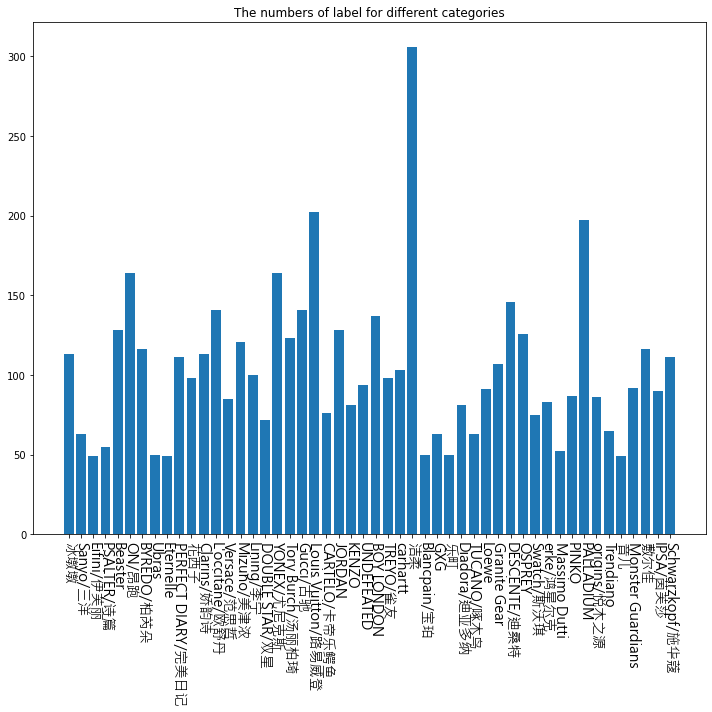

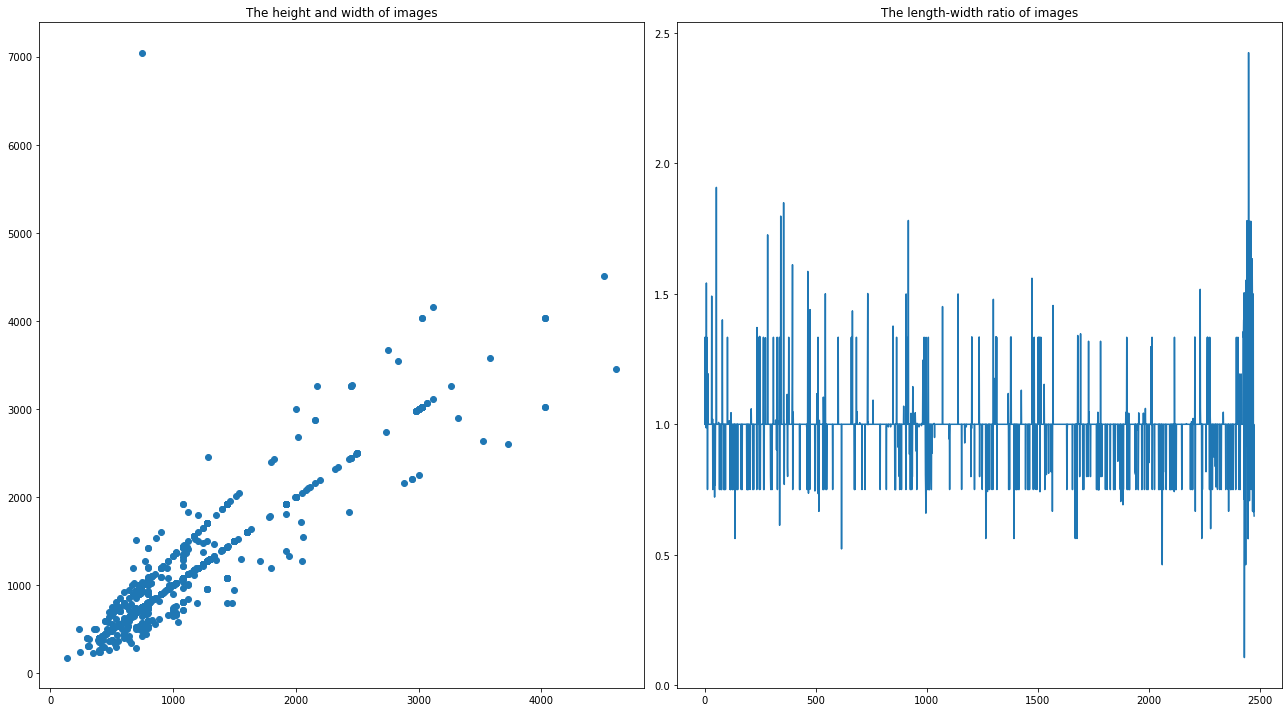

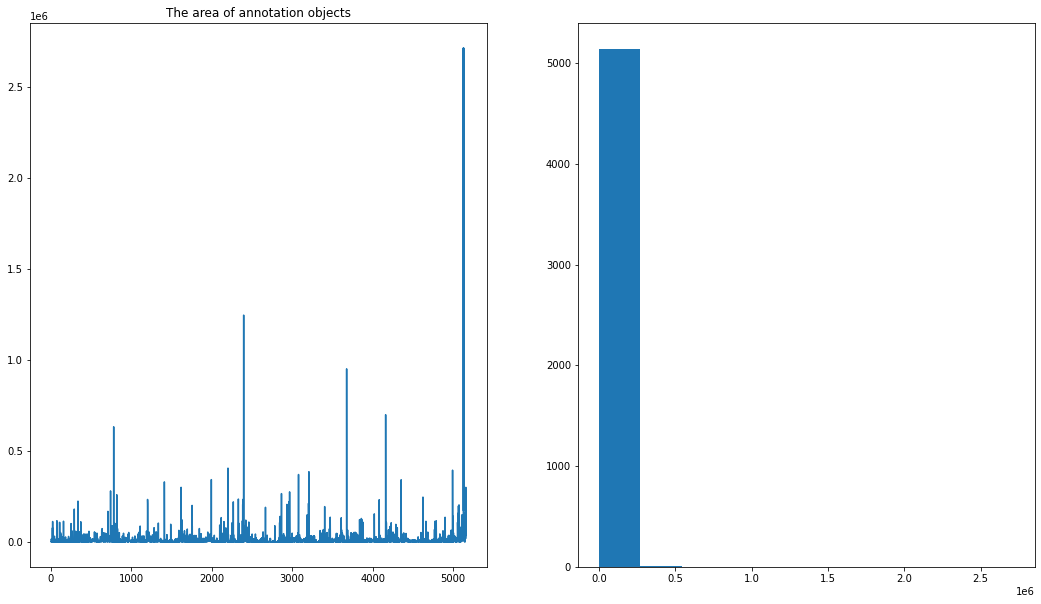

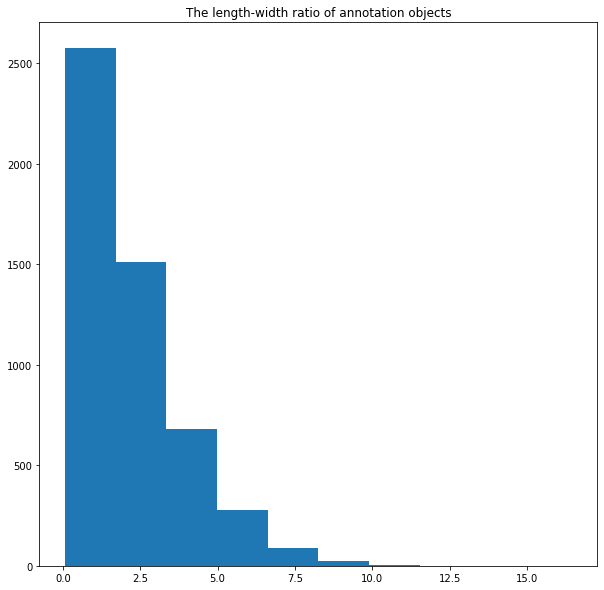

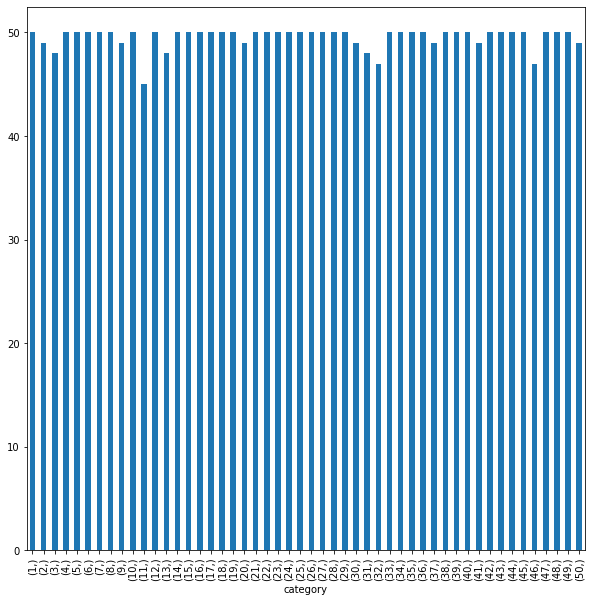

In [5]:
anno_train = train_root + '/annotations/instances_train2017.json'
print(anno_train)
dataset_analyze(anno_train)


In [8]:
anno_test = test_root + '/annotations/instances_test2017.json'
#dataset_analyze(anno_test)
with open(anno_test, 'r', encoding='utf-8') as f:
    data = json.load(f)
data.keys()

dict_keys(['info', 'license', 'images', 'categories'])

In [17]:
data.keys()

dict_keys(['info', 'license', 'images', 'annotations', 'categories'])

In [3]:
def split_dataset(anno, root_images, root_save, probability=0.8):
     import shutil
     import tqdm
     # path
     path_annos = root_save + '/annotations'
     path_images_train = root_save + '/train'
     path_images_val = root_save + '/val'
     if os.path.exists(root_save) == False:
          os.makedirs(root_save)
     if os.path.exists(path_annos) == False:
          os.mkdir(path_annos)
     if os.path.exists(path_images_train) == False:
          os.mkdir(path_images_train)
     if os.path.exists(path_images_val) == False:
          os.makedirs(path_images_val)

     with open(anno, 'r', encoding='utf-8') as f:
          data = json.load(f)
     train_set = {
          "info": data["info"],
          "license": data["license"],
          "images":[],
          "annotations":[],
          "categories": data["categories"]
          }
     val_set = {
          "info": data["info"],
          "license": data["license"],
          "images":[],
          "annotations":[],
          "categories": data["categories"]
          }
     images = data["images"]
     annotations = data["annotations"]
     image_id_train = 0
     image_id_val = 0
     anno_id_train = 0
     anno_id_val = 0
     for image in tqdm.tqdm(images):
          temp_image ={
               "height": image["height"],
               "width": image["width"],
               "id": image["id"],
               "file_name": image["file_name"],
               }
          if random.random() < probability: #training set
               for anno in annotations:
                    if anno["image_id"] > temp_image["id"]:
                         break
                    if anno["image_id"] == temp_image["id"]:
                         temp_anno = {
                              "id": anno_id_train,
                              "image_id": image_id_train,
                              "category_id": anno["category_id"],
                              "segmentation": anno["segmentation"],
                              "bbox": anno["bbox"],
                              "iscrowd": anno["iscrowd"],
                              "area": anno["area"]
                              }
                         anno_id_train += 1
                         train_set["annotations"].append(temp_anno)
               temp_image["id"] = image_id_train
               image_id_train += 1
               train_set["images"].append(temp_image)
               shutil.copyfile(root_images+temp_image["file_name"], os.path.join(path_images_train,temp_image["file_name"]))
          else:                             #valling set
               for anno in annotations:
                    if anno["image_id"] > temp_image["id"]:
                         break
                    if anno["image_id"] == temp_image["id"]:
                         temp_anno = {
                              "id": anno_id_val,
                              "image_id": image_id_val,
                              "category_id": anno["category_id"],
                              "segmentation": anno["segmentation"],
                              "bbox": anno["bbox"],
                              "iscrowd": anno["iscrowd"],
                              "area": anno["area"]
                              }
                         anno_id_val += 1
                         val_set["annotations"].append(temp_anno)
               temp_image["id"] = image_id_val
               image_id_val += 1
               val_set["images"].append(temp_image)
               shutil.copyfile(root_images+temp_image["file_name"], os.path.join(path_images_val,temp_image["file_name"]))
     
     # write jsonfile

     print("Dataset info:\n trian set has {} images.\n val set has {} images".format(str(len(train_set["images"])),str(len(val_set["images"]))))
     with open(path_annos+'/train.json', 'w', encoding='utf-8') as f:
          json.dump(train_set, f)
     with open(path_annos+'/val.json', 'w', encoding='utf-8') as f:
          json.dump(val_set, f)

In [14]:
def xywh_to_xyxy(bbox):
    x, y, w, h = bbox
    #x1 = x - w/2
    #y1 = y - h/2
    #x2 = x + w/2
    #y2 = y + h/2
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    return int(x1), int(y1), int(x2), int(y2)
def show_anno(anno, image_root, root_save=None, palette=None):
    if root_save == None:
        print('Please enter path for saving the images!')
    else:
        import tqdm
        if os.path.exists(root_save) == False:
            os.makedirs(root_save)
        with open(anno, 'r', encoding='utf-8') as f:
            data = json.load(f)
        images = data["images"]
        annotations = data["annotations"]
        categories = data["categories"]
        if palette == None:
            palette = []
            for i in range(len(categories)):
                palette.append(list(np.random.choice(range(256), size=3)))
        for image in tqdm.tqdm(images):
            file_name = image["file_name"]
            img = cv2.imread(os.path.join(image_root, file_name))
            for anno in annotations:
                if anno["image_id"] > image["id"]:
                        break
                if anno["image_id"] == image["id"]:
                    color = palette[anno["category_id"] - 1]
                    
                    x1, y1, x2, y2 = xywh_to_xyxy(anno["bbox"])
                    img = cv2.rectangle(img, (x1, y1), (x2, y2),color=(0,0,255),thickness=1)
            cv2.imwrite(os.path.join(root_save, file_name), img)
    return None
        

In [10]:
anno_train = train_root + '/annotations/instances_train2017.json'
with open(anno_train, 'r', encoding='utf-8') as f:
    data = json.load(f)
cate_name = []
for cate in data['categories']:
    cate_name.append(cate["name"])
print(cate_name)
PALETTE = [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230),
               (106, 0, 228), (0, 60, 100), (0, 80, 100), (0, 0, 70),
               (0, 0, 192), (250, 170, 30), (100, 170, 30), (220, 220, 0),
               (175, 116, 175), (250, 0, 30), (165, 42, 42), (255, 77, 255),
               (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
               (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118),
               (255, 179, 240), (0, 125, 92), (209, 0, 151), (188, 208, 182),
               (0, 220, 176), (255, 99, 164), (92, 0, 73), (133, 129, 255),
               (78, 180, 255), (0, 228, 0), (174, 255, 243), (45, 89, 255),
               (134, 134, 103), (145, 148, 174), (255, 208, 186),
               (197, 226, 255), (171, 134, 1), (109, 63, 54), (207, 138, 255),
               (151, 0, 95), (9, 80, 61), (84, 105, 51), (74, 65, 105),
               (166, 196, 102), (208, 195, 210), (255, 109, 65), (0, 143, 149),
               (179, 0, 194), (209, 99, 106), (5, 121, 0), (227, 255, 205),
               (147, 186, 208), (153, 69, 1), (3, 95, 161), (163, 255, 0),
               (119, 0, 170), (0, 182, 199), (0, 165, 120), (183, 130, 88),
               (95, 32, 0), (130, 114, 135), (110, 129, 133), (166, 74, 118),
               (219, 142, 185), (79, 210, 114), (178, 90, 62), (65, 70, 15),
               (127, 167, 115), (59, 105, 106), (142, 108, 45), (196, 172, 0),
               (95, 54, 80), (128, 76, 255), (201, 57, 1), (246, 0, 122),
               (191, 162, 208)]
print(PALETTE[:len(cate_name)])
PALETTE = PALETTE[:len(cate_name)]
print(data['categories'])
print(len(PALETTE), len(cate_name))

['冰墩墩', 'Sanyo/三洋', 'Eifini/伊芙丽', 'PSALTER/诗篇', 'Beaster', 'ON/昂跑', 'BYREDO/柏芮朵', 'Ubras', 'Eternelle', 'PERFECT DIARY/完美日记', '花西子', 'Clarins/娇韵诗', "L'occitane/欧舒丹", 'Versace/范思哲', 'Mizuno/美津浓', 'Lining/李宁', 'DOUBLE STAR/双星', 'YONEX/尤尼克斯', 'Tory Burch/汤丽柏琦', 'Gucci/古驰', 'Louis Vuitton/路易威登', 'CARTELO/卡帝乐鳄鱼', 'JORDAN', 'KENZO', 'UNDEFEATED', 'BOY LONDON', 'TREYO/雀友', 'carhartt', '洁柔', 'Blancpain/宝珀', 'GXG', '乐町', 'Diadora/迪亚多纳', 'TUCANO/啄木鸟', 'Loewe', 'Granite Gear', 'DESCENTE/迪桑特', 'OSPREY', 'Swatch/斯沃琪', 'erke/鸿星尔克', 'Massimo Dutti', 'PINKO', 'PALLADIUM', 'origins/悦木之源', 'Trendiano', '音儿', 'Monster Guardians', '敷尔佳', 'IPSA/茵芙莎', 'Schwarzkopf/施华蔻']
[(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228), (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30), (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42), (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157), (110, 76, 0), (174, 57, 255), (199, 100, 0), (72

In [15]:


show_anno(anno_train, train_root+'/images/', train_root+'/image_with_annos', PALETTE)

100%|██████████| 2476/2476 [03:28<00:00, 11.89it/s]


In [ ]:
anno_train = train_root + '/annotations/instances_train2017.json'

split_dataset(anno_train, train_root+'/images/', '/mnt/d/Github/mmdetection/project/LogDetMini/data/datasplit', probability=0.9)

100%|██████████| 2476/2476 [01:54<00:00, 21.54it/s]


Dataset info:
 trian set has 2236 images.
 val set has 240 images


The dataset totally has 2236 images, 4666 labels, and 50 categories.
Numbers of different categories:
    id                name count
0    1                 冰墩墩   109
1    2            Sanyo/三洋    56
2    3          Eifini/伊芙丽    44
3    4          PSALTER/诗篇    42
4    5             Beaster   113
5    6               ON/昂跑   149
6    7          BYREDO/柏芮朵   110
7    8               Ubras    47
8    9           Eternelle    43
9   10  PERFECT DIARY/完美日记    93
10  11                 花西子    84
11  12         Clarins/娇韵诗   106
12  13      L'occitane/欧舒丹   123
13  14         Versace/范思哲    74
14  15          Mizuno/美津浓   106
15  16           Lining/李宁    95
16  17      DOUBLE STAR/双星    61
17  18          YONEX/尤尼克斯   145
18  19     Tory Burch/汤丽柏琦   108
19  20            Gucci/古驰   125
20  21  Louis Vuitton/路易威登   188
21  22       CARTELO/卡帝乐鳄鱼    68
22  23              JORDAN   118
23  24               KENZO    78
24  25          UNDEFEATED    88
25  26          BOY LONDON   125
26  27 

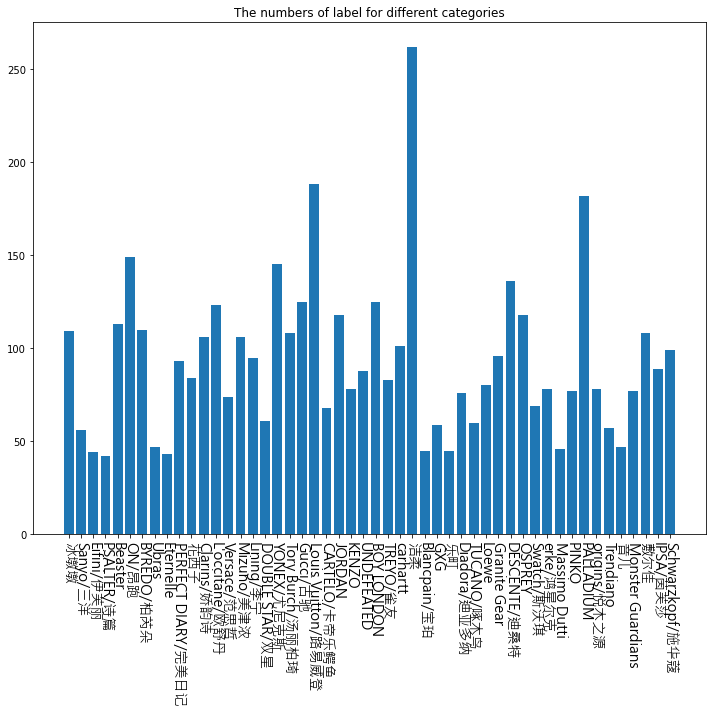

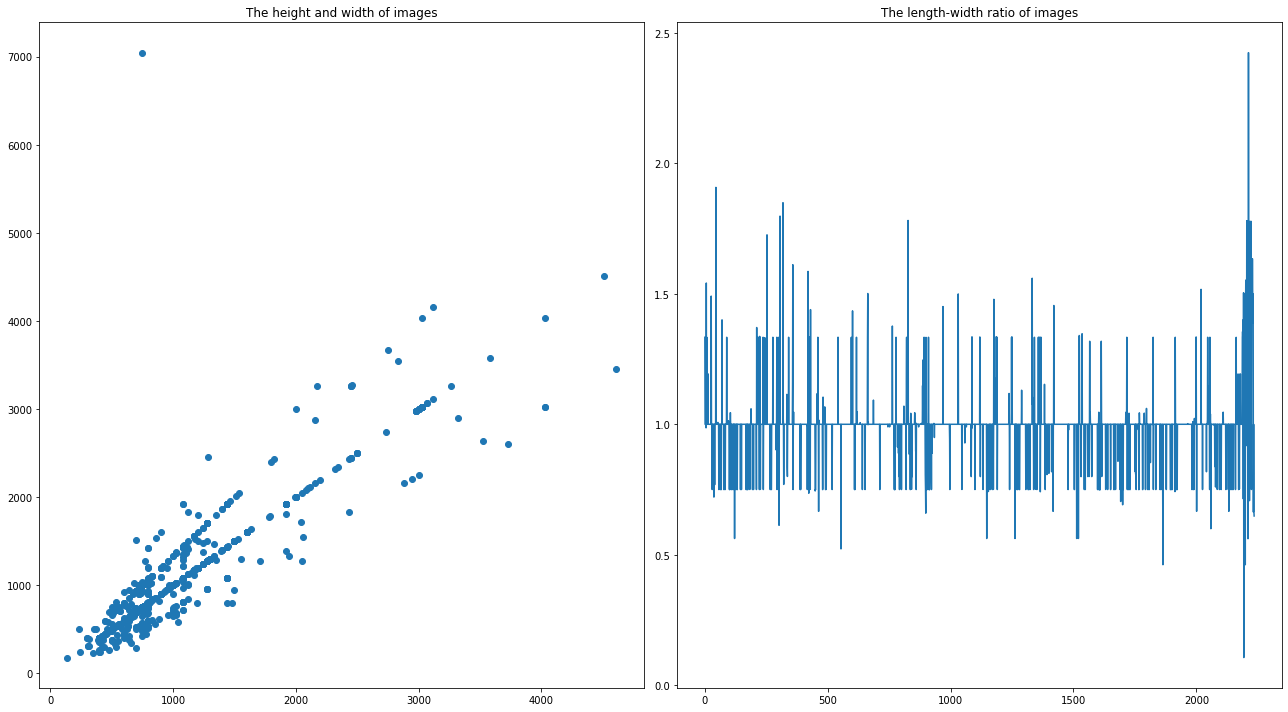

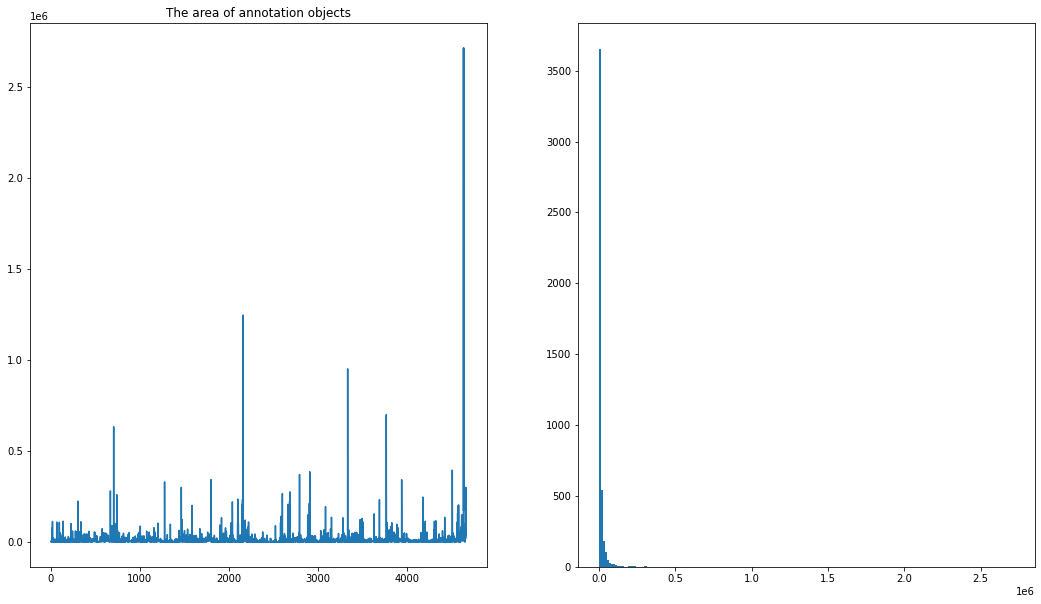

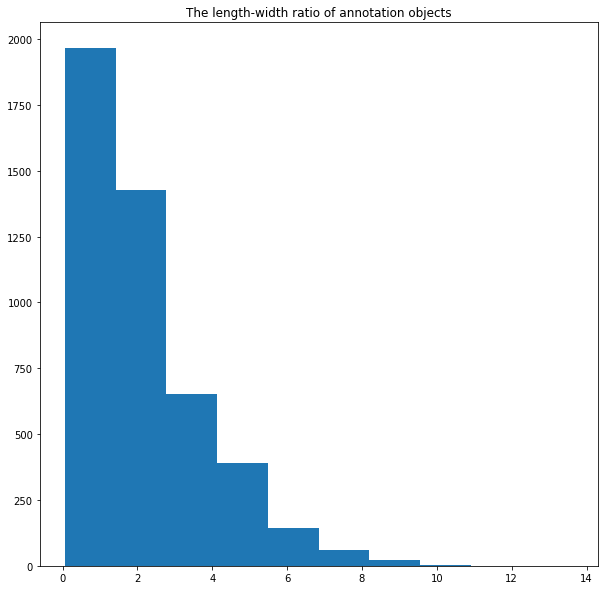

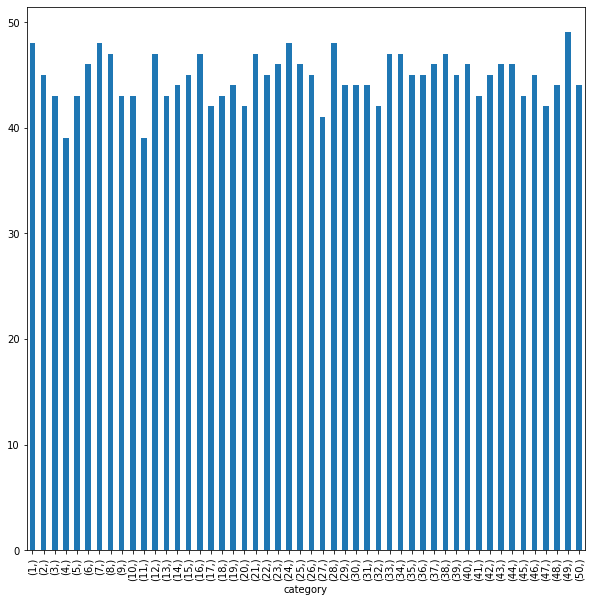

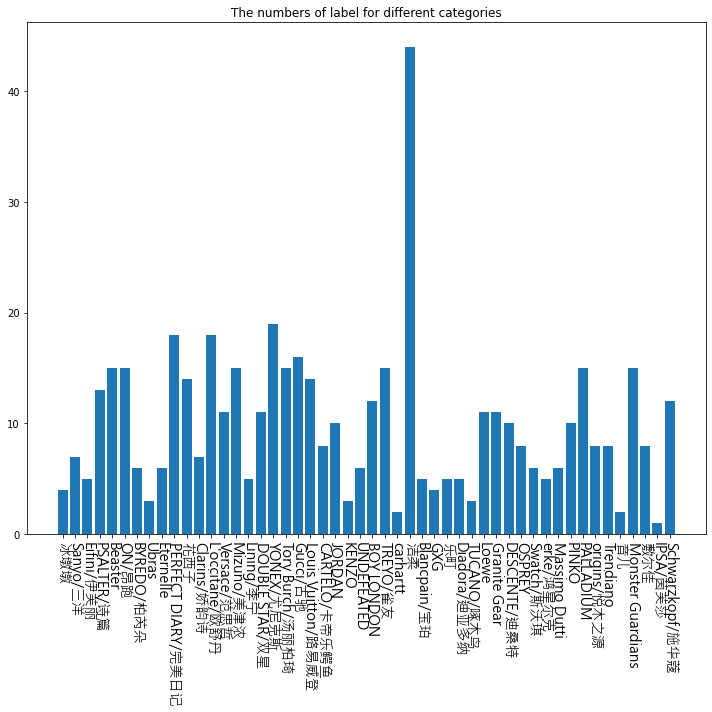

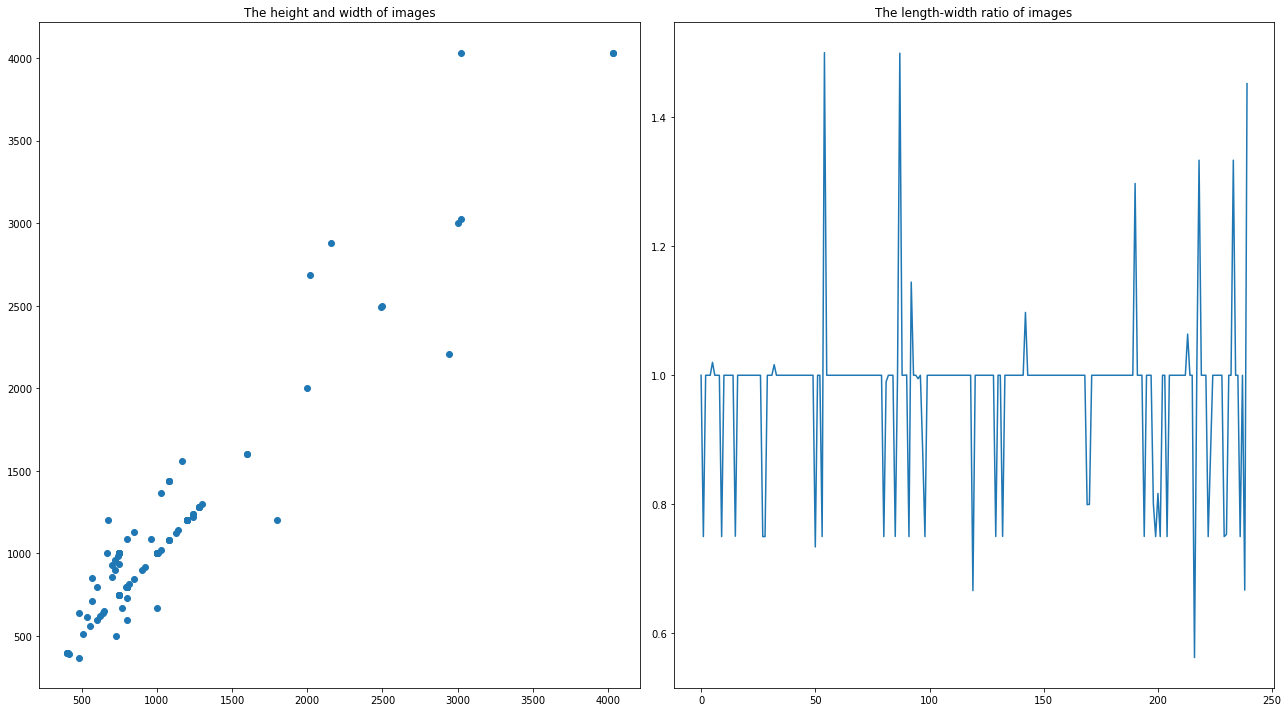

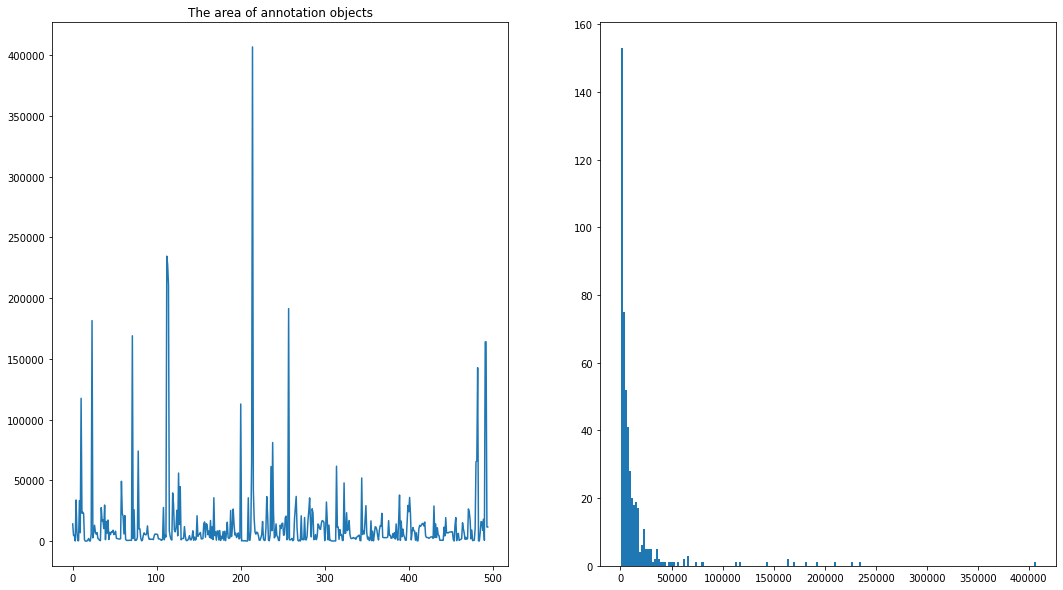

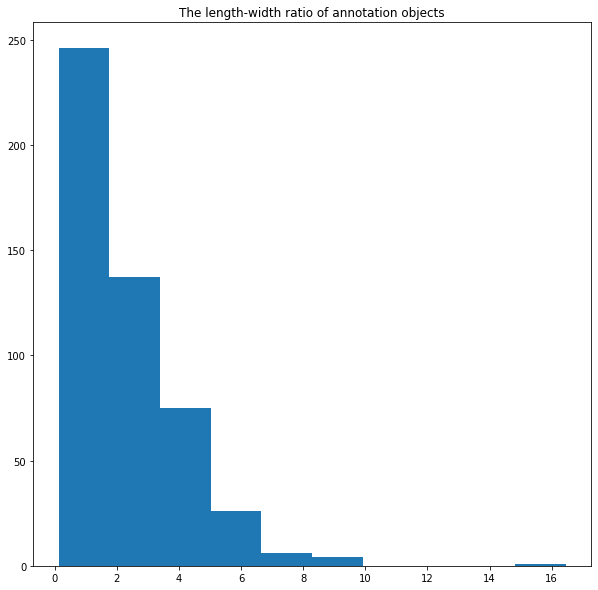

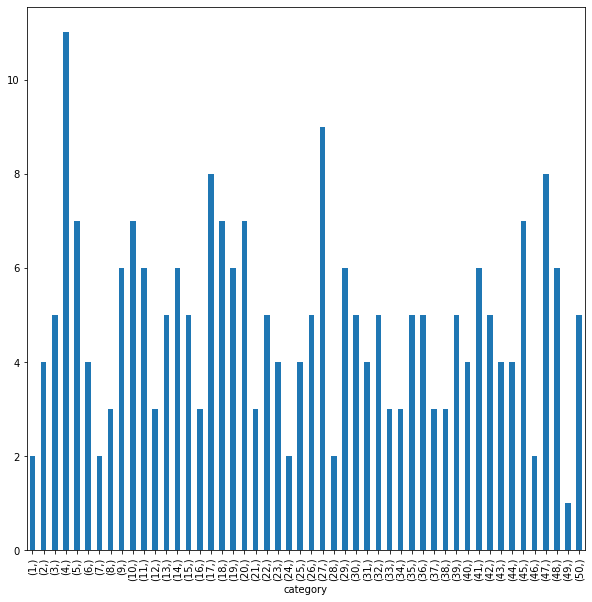

In [ ]:
dataset_analyze('/mnt/d/Github/mmdetection/project/LogDetMini/data/datasplit/annotations/train.json')
dataset_analyze('/mnt/d/Github/mmdetection/project/LogDetMini/data/datasplit/annotations/val.json')